# Lab 1: Causal Discovery based Markov Blanket Search

This notebook demonstrates:
1. Loading datasets and visualizing the DAG
2. Introducing Causal Discovery based Markov Blanket Search methods (CD-MB)
   - Evaluating causal discovery performance (NHD, precision, recall, F1)
   - Evaluating Markov Blanket feature selection performance
3. Comparing CD-MB methods

In [ ]:
%load_ext watermark
%watermark -a "Shu Wan" -v

%load_ext autoreload
%autoreload 2

In [2]:
!pip install git+https://github.com/Shu-Wan/CSE472-blanket-challenge.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.5 MB/s eta 0:

In [3]:
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from huggingface_hub import snapshot_download
from datasets import load_dataset

from blanket.datasets import load_data
from blanket.feature_selection import (
    direct_lingam_selector,
    ges_selector,
    notears_selector,
    pc_selector,
)
from blanket.metrics import adjacency_confusion, jaccard_score, reduction_rate, shd
from blanket.plots import plot_adjmat, plot_graph

## 1. Load Dataset and Visualize DAG

In [4]:
# Load dataset
datasets = load_dataset(path="CSE472-blanket-challenge/phase1-dataset", split="train")

datasets.features

README.md: 0.00B [00:00, ?B/s]

linear_train.jsonl:   0%|          | 0.00/148M [00:00<?, ?B/s]

linear_test.jsonl:   0%|          | 0.00/35.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/180 [00:00<?, ? examples/s]

{'data_id': Value('string'),
 'graph_id': Value('string'),
 'X': List(List(Value('float64'))),
 'y': List(Value('float64')),
 'adjacency_matrix': List(List(Value('int64'))),
 'feature_mask': List(Value('int64')),
 'fs_method': Value('string'),
 'num_nodes': Value('int64'),
 'num_edges': Value('int64'),
 'density': Value('float64'),
 'graph_generation_method': Value('string')}

In [5]:
example = datasets[70]
X = np.asarray(example["X"])
y = np.asarray(example["y"])
adj_mat = np.asarray(example["adjacency_matrix"])
num_nodes = example["num_nodes"]
density = example["density"]
mb = np.asarray(example["feature_mask"])

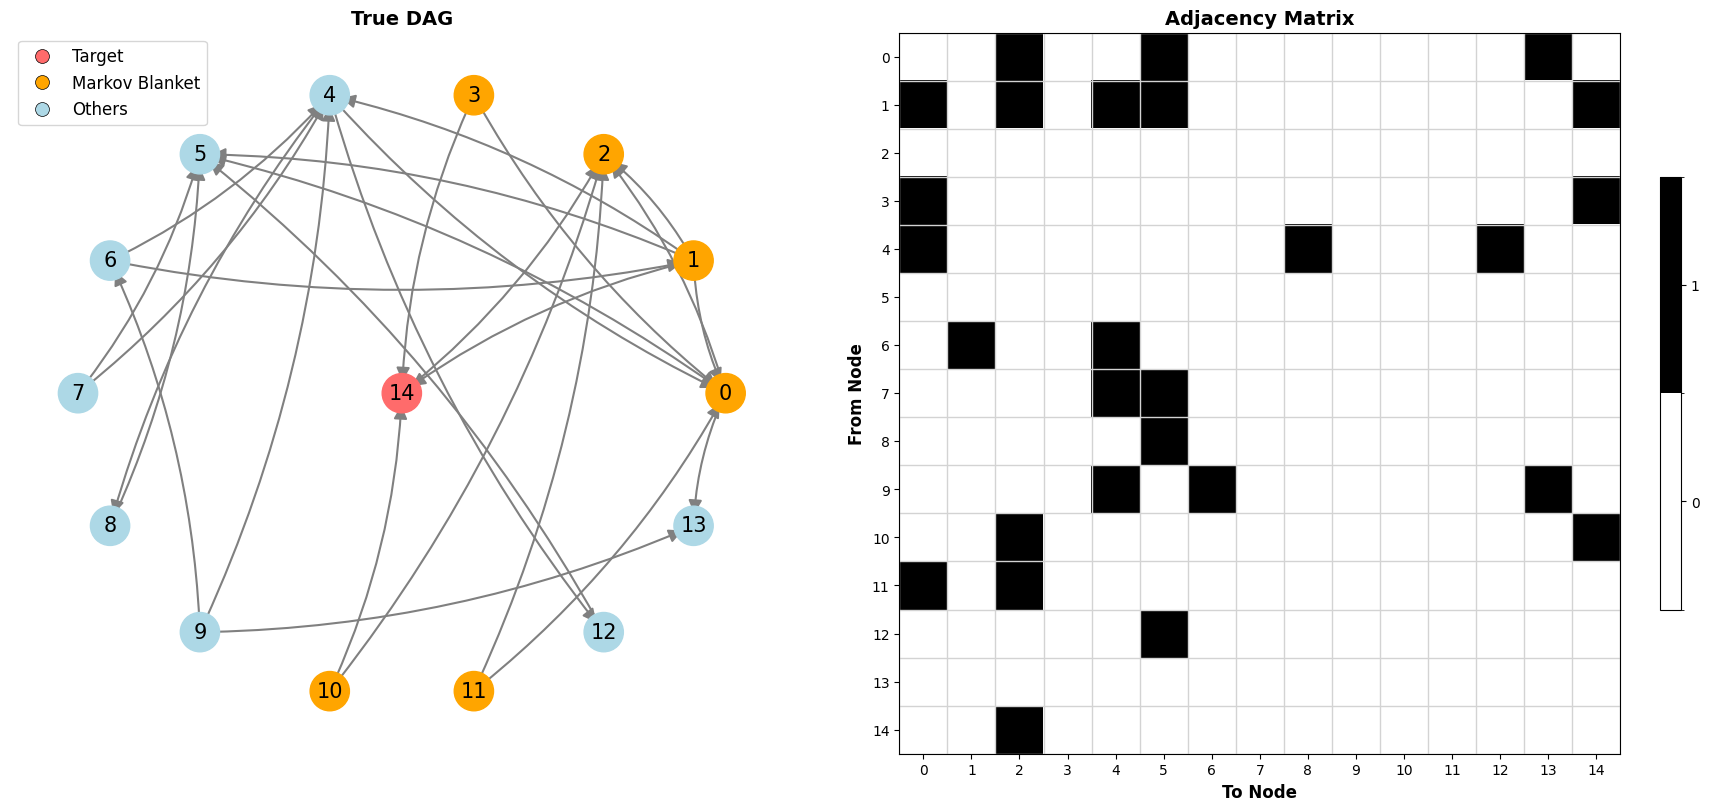

In [6]:
# Visualize True DAG and Adjacency Matrix
fig, axes = plt.subplots(1, 2, figsize=(17, 8), constrained_layout=True)

plot_graph(adj_mat, figsize=(5, 5), ax=axes[0], title="True DAG")

plot_adjmat(
    adj_mat,
    title="Adjacency Matrix",
    figsize=(5, 5),
    ax=axes[1],
)

plt.show()

## 2. Causal Discovery based Markov Blanket Search (CD-MB)

The goal is to recover a target variable's Markov blanket (its parents, children, and spouses) by first learning a causal graph and then extracting the local neighborhood.

General Workflow
- Run a causal discovery algorithm on the data.
- Sanitize the learned graph (e.g., remove implausible edges, orient CPDAG edges if needed, ensure acyclicity).
- Extract the target's Markov blanket from the cleaned graph.

Pros
- Works with any causal discovery algorithm.
- One learned graph can be reused for multiple target variables.

Cons
- Algorithm assumptions matter (e.g., causal sufficiency, faithfulness, linearity, non‑Gaussianity).
- More often than not, CD method can not return a DAG but a CPDAG (equivalence class of DAGs).
- Many CD methods do not scale well on high‑dimensional data.
- Global structure learning can be wasteful when only a local (MB) neighborhood is needed.

In this tutorial we compare four families of causal discovery methods:
- PC — constraint‑based.
- GES — score‑based.
- DirectLiNGAM — functional/ICA‑based (non‑Gaussian noise).
- NOTEARS — gradient/continuous optimization‑based (linear SEM with acyclicity penalty).

We use the [`gCastle`](https://github.com/huawei-noah/trustworthyAI/blob/master/gcastle) package for the causal discovery algorithms; see its documentation for details.

In [73]:
!pip install -q rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [74]:
%%R
install.packages("bnlearn")
library(bnlearn)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/bnlearn_5.1.tar.gz'
Content type 'application/x-gzip' length 1341966 bytes (1.3 MB)
downloaded 1.3 MB


The downloaded source packages are in
	‘/tmp/Rtmp9R9CMi/downloaded_packages’


In [75]:
from rpy2.robjects import r, pandas2ri

pandas2ri.activate()

def iamb_selector(X, y, method="iamb", alpha=0.05, test=None):
    """
    Use bnlearn's IAMB (or Fast-IAMB, Inter-IAMB, etc) to get:
      - a Markov blanket mask over X (True = in MB(Y))
      - an adjacency matrix over [X1, ..., Xp, Y]
    """
    n, d = X.shape
    feature_cols = [f"X{i}" for i in range(d)]
    target_col = "Y"

    # Build a pandas DataFrame with named columns
    df = pd.DataFrame(X, columns=feature_cols)
    df[target_col] = y

    # Send data frame to R
    r_df = pandas2ri.py2rpy(df)
    r.assign("df_py", r_df)

    # Load bnlearn in R session
    r("library(bnlearn)")

    # Choose a test, default depends on variable type
    if test is None:
        test_arg = ""
    else:
        test_arg = f', test="{test}"'

    # 1) Learn the Markov blanket of Y with learn.mb (specialised MB learner)
    r(f'''
        mb_nodes <- learn.mb(df_py,
                             node="{target_col}",
                             method="{method}",
                             alpha={alpha}{test_arg})
    ''')

    mb_nodes = list(r["mb_nodes"])

    # Convert MB node labels back to a boolean mask over X columns only
    mb_mask = np.array([1 if name in mb_nodes else 0 for name in feature_cols], dtype=int)

    # 2) Learn a full network with IAMB to get an adjacency matrix
    r(f'''
        bn_struct <- {method}(df_py, alpha={alpha}{test_arg})
        amat_mat <- amat(bn_struct)
    ''')
    adj_mat = (np.array(r["amat_mat"], dtype=int) > 0).astype(int)

    return mb_mask, adj_mat

In [76]:
pc_feature, pc_adjmat = pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable")
ges_feature, ges_adjmat = ges_selector(X, y, criterion="bic", method="scatter")
direct_lingam_feature, direct_lingam_adjmat = direct_lingam_selector(
    X, y, measure="pwling", thresh=0.3
)
notears_feature, notears_adjmat = notears_selector(X, y, lambda1=0.1, loss_type="l2")
iamb_feature, iamb_adjmat = iamb_selector(X, y)

Some CD algos returns a class of graph called CPDAG, CPDAG contains undirected edges when the direction cannot be determined from conditional independence tests alone.

For MB, we allow bidirectional edges

Some causal discovery methods return a CPDAG*, an equivalence class that includes undirected edges when orientation cannot be determined from conditional independence tests alone. For Markov‑blanket extraction, a partially oriented graph is acceptable; we permit undirected (bidirectional) edges. The minimal Markov blanket is known as the Markov boundary.

\*: Proposition 11.1, Introduction to Causal Inference

In [77]:
G = nx.from_numpy_array(pc_adjmat, create_using=nx.DiGraph)
nx.is_directed_acyclic_graph(G)

False

In [80]:
# Compute graph metrics (SHD, precision, recall, F1) and MB metrics for each discovered graph

cdmb_results = {
    "PC": (pc_feature, pc_adjmat),
    "GES": (ges_feature, ges_adjmat),
    "DirectLiNGAM": (direct_lingam_feature, direct_lingam_adjmat),
    "NOTEARS": (notears_feature, notears_adjmat),
    "IAMB": (iamb_feature, iamb_adjmat),
}

rows = []
for name, results in cdmb_results.items():
    feature = results[0]
    adj = results[1]
    shd_val = shd(adj_mat, adj)
    precision, recall, f1 = adjacency_confusion(adj_mat, adj)

    mb_jaccard = jaccard_score(mb, feature)
    mb_size = int(np.sum(feature))
    mb_reduction = reduction_rate(feature)

    rows.append(
        {
            "Method": name,
            "SHD": int(shd_val),
            "Precision": float(precision),
            "Recall": float(recall),
            "F1 Score": float(f1),
            "MB Jaccard": float(mb_jaccard),
            "MB Size": mb_size,
            "Reduction Rate": float(mb_reduction),
        }
    )

# Create and display comparison table
comparison_df = pd.DataFrame(rows)
comparison_df.sort_values(by="F1 Score", ascending=False, inplace=False).reset_index(drop=True)


,Method,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,PC,12,0.857143,0.666667,0.750000,0.333333,2,0.857143
1,IAMB,16,0.720000,0.666667,0.692308,1.000000,6,0.571429
2,GES,34,0.414634,0.629630,0.500000,0.833333,5,0.642857
3,NOTEARS,20,0.888889,0.296296,0.444444,0.333333,2,0.857143
4,DirectLiNGAM,36,0.320000,0.296296,0.307692,0.500000,3,0.785714


From the result above, NoTEARS performs best on Precision and IAMB on MB Jaccard.

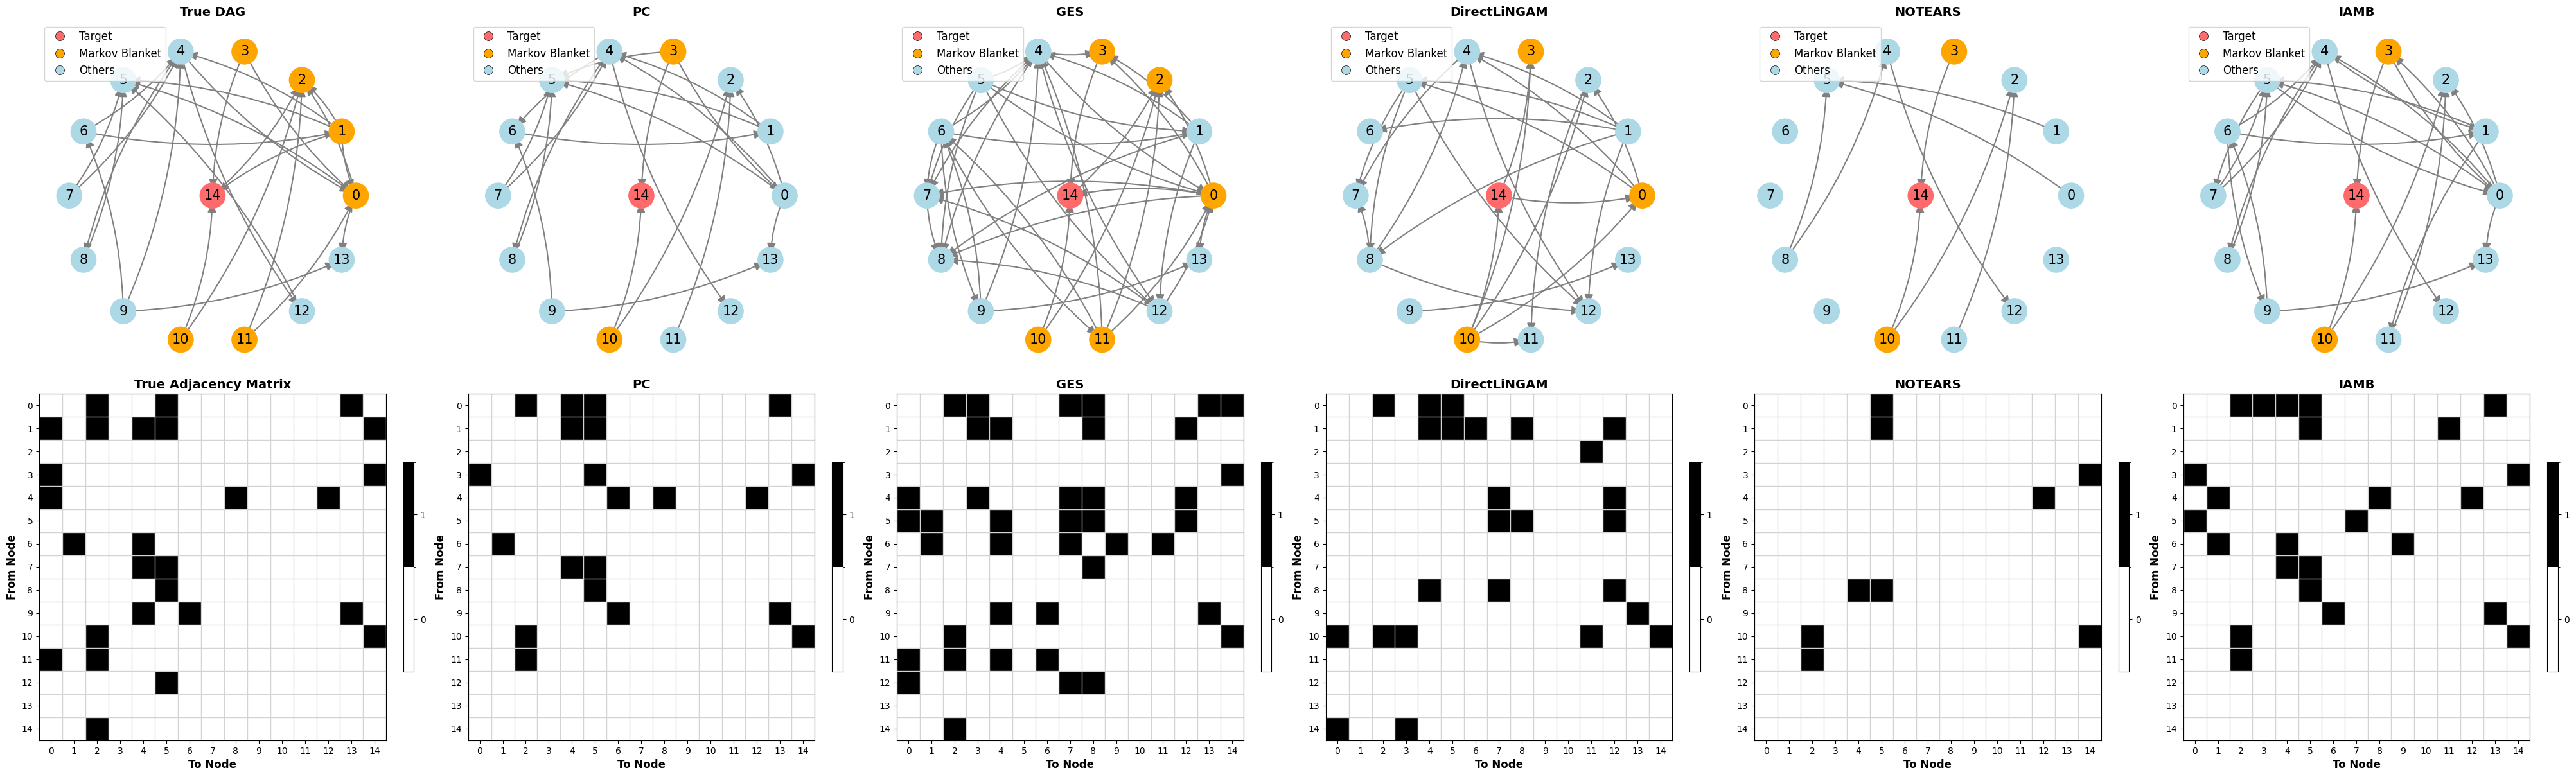

In [81]:
# visualize the results

num_methods = len(cdmb_results)
fig, axes = plt.subplots(2, num_methods + 1, figsize=(num_methods * 8, 12), constrained_layout=True)

plot_graph(
    adj_mat,
    figsize=(5, 5),
    title="True DAG",
    ax=axes[0, 0],
)

plot_adjmat(
    adj_mat,
    title="True Adjacency Matrix",
    figsize=(5, 5),
    ax=axes[1, 0],
)

for i, (name, results) in enumerate(cdmb_results.items(), 1):
    adj = results[1]
    plot_graph(
        adj,
        figsize=(5, 5),
        title=f"{name}",
        ax=axes[0, i],
    )

    plot_adjmat(
        adj,
        title=f"{name}",
        figsize=(5, 5),
        ax=axes[1, i],
    )

plt.show()

## 4. Scale up

The above is just a small demo on one graph. Next, we run all CD-MB methods on 10 graphs, record time, and compare results.

In [82]:
import time

# Set random seed for reproducibility
np.random.seed(42)

# Sample 10 graphs from the dataset
n_graphs = 10
sample_indices = np.random.choice(len(datasets), size=n_graphs, replace=False)

# Initialize results storage
all_results = []

# Run all CD algos on each sampled graph
for idx, sample_idx in enumerate(tqdm(sample_indices, total=n_graphs, desc="Processing graphs", unit="graph")):

    example = datasets[int(sample_idx)]

    # Reconstruct the DAG from adjacency matrix
    X = np.asarray(example["X"])
    y = np.asarray(example["y"])
    adj_mat = np.asarray(example["adjacency_matrix"])
    num_nodes = example["num_nodes"]
    num_edges = example["num_edges"]
    density = example["density"]
    oracle_mb = np.asarray(example["feature_mask"])

    # Run each algorithm and record time and results
    algorithms = {
        "PC": lambda: pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable"),
        "GES": lambda: ges_selector(X, y, criterion="bic", method="scatter"),
        "DirectLiNGAM": lambda: direct_lingam_selector(X, y, measure="pwling", thresh=0.3),
        "NOTEARS": lambda: notears_selector(X, y, lambda1=0.1, loss_type="l2"),
        "IAMB": lambda: iamb_selector(X, y),
    }

    for algo_name, algo_func in algorithms.items():
        # Record time
        start_time = time.time()
        try:
            feature, discovered_adj = algo_func()
            end_time = time.time()
            runtime = end_time - start_time

            # Compute graph discovery metrics
            shd_val = shd(adj_mat, discovered_adj)
            precision, recall, f1 = adjacency_confusion(adj_mat, discovered_adj)

            # Compute MB metrics
            mb_jaccard = jaccard_score(oracle_mb, feature)
            mb_size = int(np.sum(feature))
            mb_reduction = reduction_rate(feature)
            oracle_mb_size = int(np.sum(oracle_mb))

            # Store results
            all_results.append({
                "Graph Index": sample_idx,
                "Graph ID": idx + 1,
                "Algorithm": algo_name,
                "Runtime (s)": runtime,
                "Num Nodes": num_nodes,
                "Num Edges": num_edges,
                "Density": density,
                "Oracle MB Size": oracle_mb_size,
                "SHD": int(shd_val),
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "MB Jaccard": mb_jaccard,
                "MB Size": mb_size,
                "Reduction Rate": mb_reduction,
            })
        except Exception as e:
            print(f"  Error in {algo_name}: {str(e)}")
            continue

# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df.head(10)

Processing graphs:   0%|          | 0/10 [00:00<?, ?graph/s]

,Graph Index,Graph ID,Algorithm,Runtime (s),Num Nodes,Num Edges,Density,Oracle MB Size,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,340,1,PC,1.206807,20,54,0.142105,12,45,0.628571,0.407407,0.494382,0.692308,10,0.473684
1,340,1,GES,29.849420,20,54,0.142105,12,57,0.476190,0.555556,0.512821,0.785714,13,0.315789
2,340,1,DirectLiNGAM,2.140945,20,54,0.142105,12,49,0.571429,0.370370,0.449438,0.666667,8,0.578947
3,340,1,NOTEARS,34.229793,20,54,0.142105,12,44,0.857143,0.222222,0.352941,0.083333,1,0.947368
4,340,1,IAMB,0.591968,20,54,0.142105,12,45,0.615385,0.444444,0.516129,0.750000,9,0.526316
5,290,2,PC,0.185540,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.777778,7,0.222222
6,290,2,GES,1.879985,10,24,0.266667,9,31,0.379310,0.458333,0.415094,1.000000,9,0.000000
7,290,2,DirectLiNGAM,0.294922,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.888889,8,0.111111
8,290,2,NOTEARS,1.474443,10,24,0.266667,9,17,1.000000,0.291667,0.451613,0.444444,4,0.555556
9,290,2,IAMB,0.126930,10,24,0.266667,9,25,0.470588,0.333333,0.390244,0.888889,8,0.111111


In [83]:
# Summary by algorithm
summary_by_algo = results_df.groupby("Algorithm").agg({
    "Runtime (s)": ["mean", "std", "min", "max"],
    "SHD": ["mean", "std"],
    "Precision": ["mean", "std"],
    "Recall": ["mean", "std"],
    "F1 Score": ["mean", "std"],
    "MB Jaccard": ["mean", "std"],
    "Reduction Rate": ["mean", "std"],
}).round(4)

summary_by_algo

Runtime (s)                             SHD          Precision  \
                    mean      std     min      max  mean      std      mean   
Algorithm                                                                     
DirectLiNGAM      1.8189   1.1857  0.2949   3.9371  39.7  22.8427    0.5522   
GES              21.3593  20.7188  1.4776  70.6768  41.1  41.1837    0.5739   
IAMB              0.3610   0.2976  0.1269   1.0632  33.8  26.5907    0.6333   
NOTEARS          14.1094  13.6184  1.4744  35.0823  34.1  21.7891    0.8908   
PC                0.9286   0.6210  0.1818   1.9284  37.9  28.0295    0.5932   

                      Recall         F1 Score         MB Jaccard          \
                 std    mean     std     mean     std       mean     std   
Algorithm                                                                  
DirectLiNGAM  0.0889  0.3405  0.0773   0.4192  0.0820     0.5069  0.4228   
GES           0.1651  0.6477  0.1364   0.6054  0.1459     0.7303  0.2360   
IAMB          0.1135  0.4945  0.1983   0.5457  0.1701     0.7867  0.2375   
NOTEARS       0.1400  0.2369  0.0660   0.3705  0.0921     0.1686  0.1927   
PC            0.1363  0.4091  0.1443   0.4808  0.1457     0.5196  0.2581   

             Reduction Rate          
                       mean     std  
Algorithm                            
DirectLiNGAM         0.6616  0.3271  
GES                  0.5458  0.2905  
IAMB                 0.5981  0.2796  
NOTEARS              0.9057  0.1354  
PC                   0.6351  0.1917

## 4.1 Compare Algorithm Performance

In [84]:
# Summary Table: Runtime Performance
print("\n" + "="*100)
print("SUMMARY: RUNTIME PERFORMANCE BY ALGORITHM")
print("="*100 + "\n")

runtime_summary = results_df.groupby("Algorithm")["Runtime (s)"].agg(["count", "mean", "std", "min", "max"]).round(4)
runtime_summary.columns = ["Count", "Mean (s)", "Std (s)", "Min (s)", "Max (s)"]
runtime_summary


SUMMARY: RUNTIME PERFORMANCE BY ALGORITHM



,Count,Mean (s),Std (s),Min (s),Max (s)
Algorithm,,,,,
DirectLiNGAM,10,1.8189,1.1857,0.2949,3.9371
GES,10,21.3593,20.7188,1.4776,70.6768
IAMB,10,0.3610,0.2976,0.1269,1.0632
NOTEARS,10,14.1094,13.6184,1.4744,35.0823
PC,10,0.9286,0.6210,0.1818,1.9284


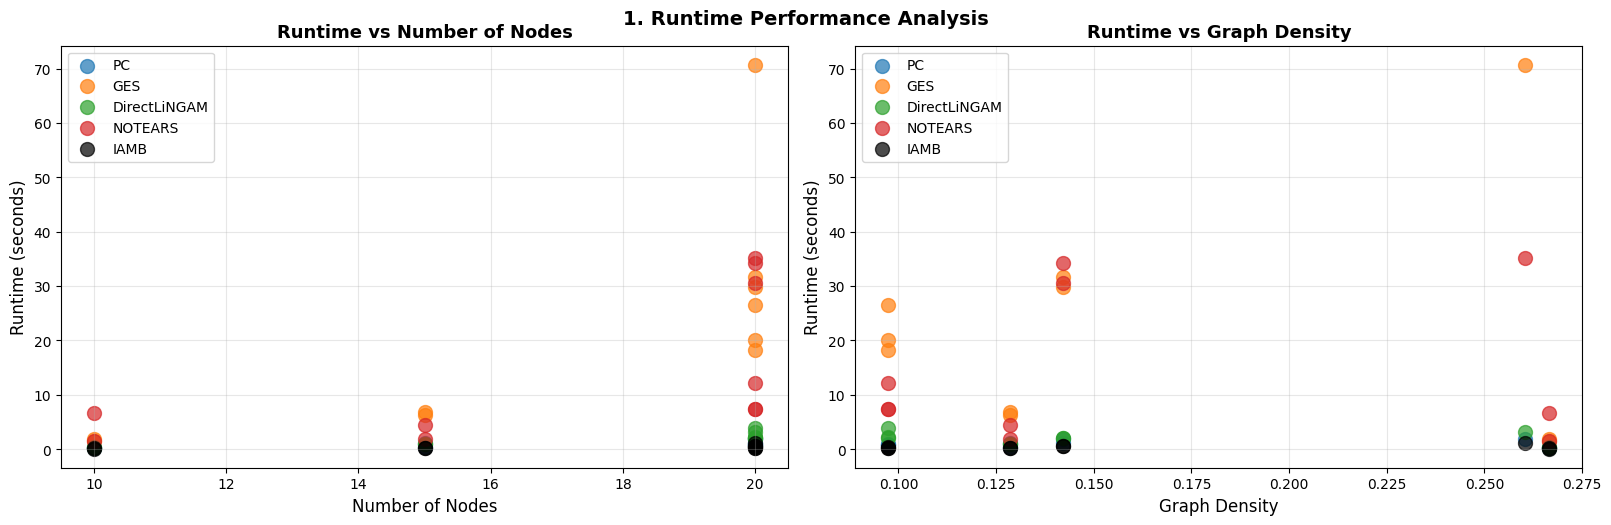

In [85]:
# Define color palette for algorithms
algo_colors = {
    "PC": "#1f77b4",
    "GES": "#ff7f0e",
    "DirectLiNGAM": "#2ca02c",
    "NOTEARS": "#d62728",
    "IAMB": "#000000"
}

# Create figure with subplots for Runtime vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: Runtime vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["Runtime (s)"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("Runtime (seconds)", fontsize=12)
axes[0].set_title("Runtime vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Runtime vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["Runtime (s)"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("Runtime (seconds)", fontsize=12)
axes[1].set_title("Runtime vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle("1. Runtime Performance Analysis", fontsize=14, fontweight="bold", y=1.02)
plt.show()


In [86]:
# Summary Table: Graph Discovery Performance (F1 Score)
print("\n" + "="*100)
print("SUMMARY: GRAPH DISCOVERY PERFORMANCE (F1 SCORE) BY ALGORITHM")
print("="*100 + "\n")

f1_summary = results_df.groupby("Algorithm")[["SHD", "Precision", "Recall", "F1 Score"]].agg(["mean", "std"]).round(4)
f1_summary


SUMMARY: GRAPH DISCOVERY PERFORMANCE (F1 SCORE) BY ALGORITHM



SHD          Precision          Recall         F1 Score        
              mean      std      mean     std    mean     std     mean     std
Algorithm                                                                     
DirectLiNGAM  39.7  22.8427    0.5522  0.0889  0.3405  0.0773   0.4192  0.0820
GES           41.1  41.1837    0.5739  0.1651  0.6477  0.1364   0.6054  0.1459
IAMB          33.8  26.5907    0.6333  0.1135  0.4945  0.1983   0.5457  0.1701
NOTEARS       34.1  21.7891    0.8908  0.1400  0.2369  0.0660   0.3705  0.0921
PC            37.9  28.0295    0.5932  0.1363  0.4091  0.1443   0.4808  0.1457

Note that I did not optimize hyperparameters for each method; better performance may be possible with tuning.

F1 score std is fairly high compared to mean, indicating one hyperparameter setting may not fit all graphs well.

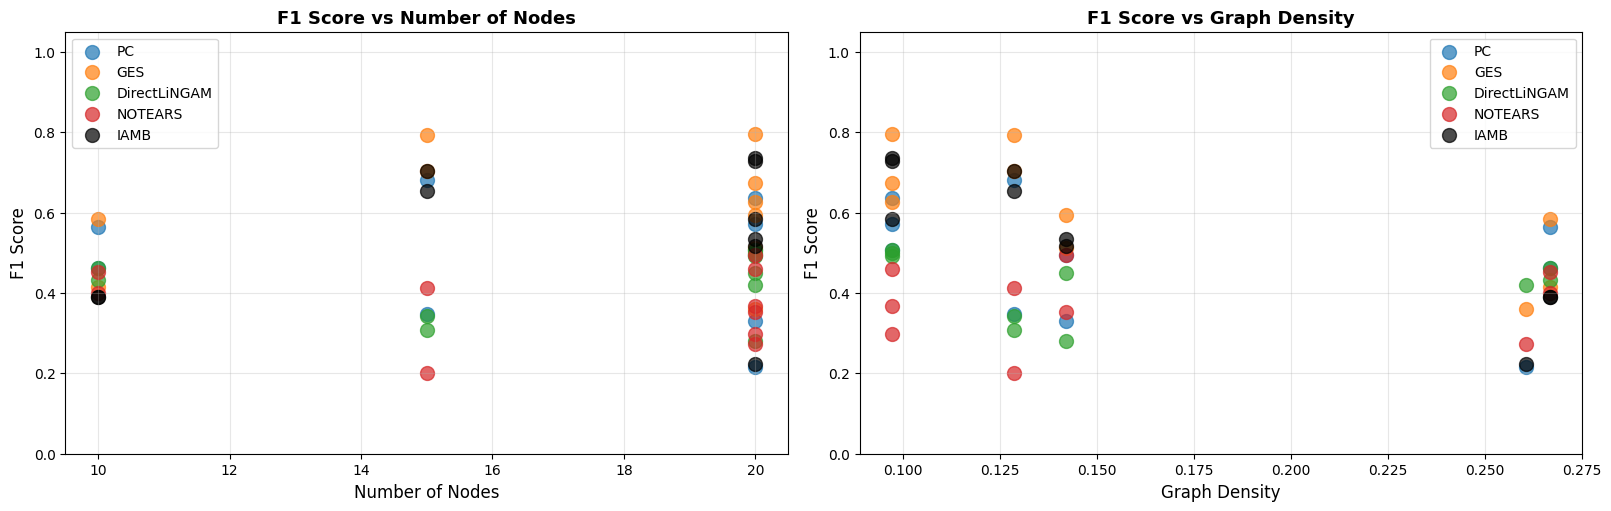

In [87]:
# Create figure with subplots for F1 Score vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: F1 Score vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["F1 Score"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("F1 Score", fontsize=12)
axes[0].set_title("F1 Score vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: F1 Score vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["F1 Score"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("F1 Score", fontsize=12)
axes[1].set_title("F1 Score vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.show()


In [88]:
# Summary Table: Markov Blanket Feature Selection Performance
print("\n" + "="*100)
print("SUMMARY: MARKOV BLANKET FEATURE SELECTION PERFORMANCE BY ALGORITHM")
print("="*100 + "\n")

mb_summary = results_df.groupby("Algorithm")[["MB Jaccard", "MB Size", "Reduction Rate"]].agg(["mean", "std"]).round(4)
print(mb_summary)


SUMMARY: MARKOV BLANKET FEATURE SELECTION PERFORMANCE BY ALGORITHM

             MB Jaccard         MB Size         Reduction Rate        
                   mean     std    mean     std           mean     std
Algorithm                                                             
DirectLiNGAM     0.5069  0.4228     5.1  5.1737         0.6616  0.3271
GES              0.7303  0.2360     6.9  4.4585         0.5458  0.2905
IAMB             0.7867  0.2375     6.2  4.5166         0.5981  0.2796
NOTEARS          0.1686  0.1927     1.2  1.3984         0.9057  0.1354
PC               0.5196  0.2581     5.5  2.6352         0.6351  0.1917


MB performance is aligned with graph discovery performance

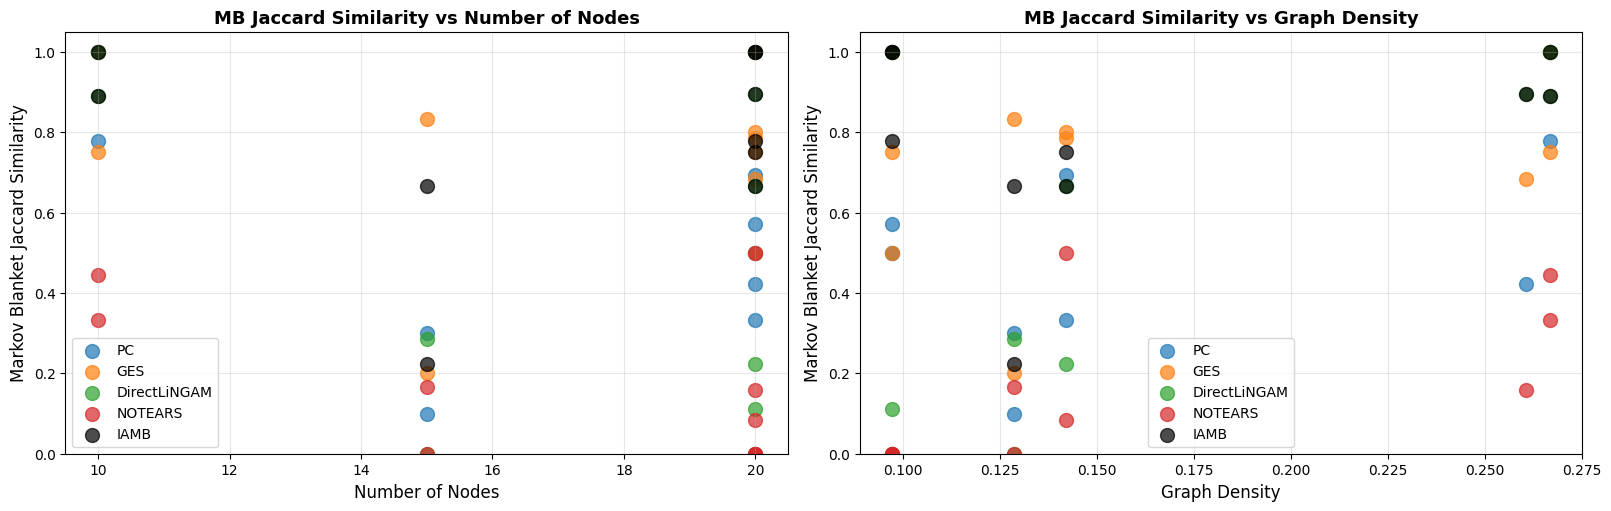

In [89]:
# Create figure with subplots for Jaccard Similarity vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: MB Jaccard vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["MB Jaccard"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("Markov Blanket Jaccard Similarity", fontsize=12)
axes[0].set_title("MB Jaccard Similarity vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: MB Jaccard vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["MB Jaccard"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("Markov Blanket Jaccard Similarity", fontsize=12)
axes[1].set_title("MB Jaccard Similarity vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.show()


## 4.2 Markov Blanket Analysis: Relationship between MB Size, Density, and Graph Structure

By definition, a MB of $Y$ shield $Y$ from the rest of the features:

$$P(Y | MB(Y), Z) = P(Y | MB(Y))$$

,where $Z \in X\setminus \{Y, MB(Y)\}$.

From this definition, we can infer that the all features, i.e $X \setminus \{Y\}$, is a trivial MB of $Y$.

Therefore, if a MB is close to the size of all features, it is not very useful to do MB search.
In the following, for each graph, we iterate through all nodes and calculate their MBs to understand how MB size relates to graph density and structure.

In [90]:
from blanket.graph import get_markov_blanket

# Compute MB for all nodes in each graph
mb_analysis_data = []

for graph_idx, sample_idx in enumerate(sample_indices):
    example = datasets[int(sample_idx)]
    adj_mat = np.asarray(example["adjacency_matrix"])
    num_nodes = example["num_nodes"]
    num_edges = example["num_edges"]
    density = example["density"]

    # Compute MB for each node
    for node_id in range(num_nodes):
        mb = get_markov_blanket(adj_mat, node_id)
        mb_size = sum(mb)
        mb_ratio = mb_size / (num_nodes - 1)

        mb_analysis_data.append({
            "Graph Index": sample_idx,
            "Graph ID": graph_idx + 1,
            "Node ID": node_id,
            "Num Nodes": num_nodes,
            "Num Edges": num_edges,
            "Density": density,
            "MB Size": mb_size,
            "MB Ratio": mb_ratio,
        })

mb_analysis_df = pd.DataFrame(mb_analysis_data)


In [91]:
mb_analysis_df.groupby("Graph ID")[["MB Ratio", "Density", "Num Nodes"]].agg(["mean", "std"]).round(4)

MB Ratio         Density      Num Nodes     
             mean     std    mean  std      mean  std
Graph ID                                             
1          0.4737  0.2180  0.1421  0.0      20.0  0.0
2          0.8000  0.2015  0.2667  0.0      10.0  0.0
3          0.3895  0.2136  0.0974  0.0      20.0  0.0
4          0.3211  0.2020  0.0974  0.0      20.0  0.0
5          0.4762  0.2237  0.1286  0.0      15.0  0.0
6          0.3737  0.2213  0.1421  0.0      20.0  0.0
7          0.8222  0.1974  0.2667  0.0      10.0  0.0
8          0.4667  0.2158  0.1286  0.0      15.0  0.0
9          0.7526  0.1999  0.2605  0.0      20.0  0.0
10         0.3211  0.2020  0.0974  0.0      20.0  0.0

1. When density exceeds 0.2, the average MB ratio is over 0.7. Noted that it already includes trivial nodes such as the root node with a limited MB. In practice, target variables are typically meaningful and thus not trivial. Hence, the average MB ratio could even be larger.
2. Consequently, in many cases, identifying the MB is not particularly informative.
3. It may seem counterintuitive, but densities of 0.1–0.2 are not sparse. Truly sparse graphs usually have densities below 0.001, which generally requires a large number of nodes (>1000). We leave this for future work.

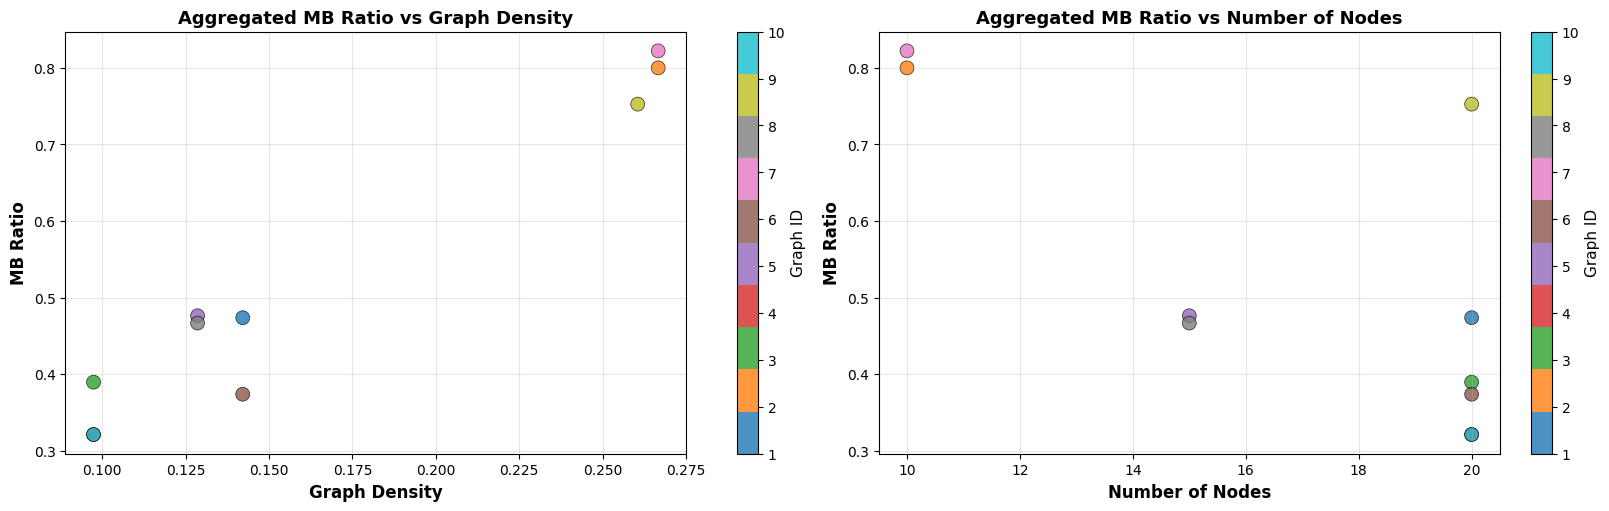

In [92]:
# Aggregate MB Ratio by Graph ID
aggregated_mb_df = mb_analysis_df.groupby("Graph ID").agg({
    "MB Ratio": "mean",
    "Density": "mean",
    "Num Nodes": "mean"
}).reset_index()

# Visualization: Aggregated MB Ratio vs Graph Properties (colored by Graph ID)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: Aggregated MB Ratio vs Density with Graph ID coloring
scatter1 = axes[0].scatter(aggregated_mb_df["Density"], aggregated_mb_df["MB Ratio"],
                           c=aggregated_mb_df["Graph ID"], cmap="tab10",
                           s=100, alpha=0.8, edgecolors="black", linewidth=0.5)
axes[0].set_xlabel("Graph Density", fontsize=12, fontweight="bold")
axes[0].set_ylabel("MB Ratio", fontsize=12, fontweight="bold")
axes[0].set_title("Aggregated MB Ratio vs Graph Density", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label("Graph ID", fontsize=11)

# Plot 2: Aggregated MB Ratio vs Num Nodes with Graph ID coloring
scatter2 = axes[1].scatter(aggregated_mb_df["Num Nodes"], aggregated_mb_df["MB Ratio"],
                           c=aggregated_mb_df["Graph ID"], cmap="tab10",
                           s=100, alpha=0.8, edgecolors="black", linewidth=0.5)
axes[1].set_xlabel("Number of Nodes", fontsize=12, fontweight="bold")
axes[1].set_ylabel("MB Ratio", fontsize=12, fontweight="bold")
axes[1].set_title("Aggregated MB Ratio vs Number of Nodes", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label("Graph ID", fontsize=11)

plt.show()

## Bonus

1. [5 point] Implement a specialized causal feature selection method (IAMB)
- [bnlearn](https://github.com/cran/bnlearn) implements IAMB, fastIAMB. Using [rpy2](https://rpy2.github.io/) or write a R script to run it (if you're familiar with R).
- [py-tetrad](https://github.com/cmu-phil/py-tetrad) also provides IAMB implementations.
2. Is dedicated causal feature selection method (IAMB) working better than causal discovery methods?

As shown in the results above, **IAMB**  achieves the highest MB Jaccard similarity score across all other algorithms. Thus, **IAMB** is working better than causal discovery methods.

Though, it should be mentioned that IAMB is **not** the best at recovering entire DAG structures. GES outperforms IAMB in that aspect. This is expected, because IAMB is not a global causal discovery method. It only needs local conditional independence relations around Y.